## Environment Setup and Initialization

This section sets up the foundational environment for our face reconstruction experiments. We:

- Mount Google Drive for model persistence

- Set random seeds for reproducibility

- Check GPU availability to accelerate training

The modifications we'll test should show benefits in both computational efficiency (measured here) and parameter count.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
from google.colab import drive

# Mount Google Drive for saving models
drive.mount('/content/drive')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda

## Data Loading and Preparation
We use the CelebA dataset containing 202,599 face images with 40 binary attributes. Key modifications from original paper:

- Process only first 20,000 samples for faster iteration

- Use 144x144 resolution (original used 128x128)

- Split: 70% train, 15% val, 15% test

Our DenseNet architecture should handle this resolution more efficiently than the original model.

In [ ]:
## 1. Data Loading and Preparation (Full Dataset)

class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_df, transform=None):
        self.img_dir = img_dir
        self.attr_df = attr_df
        self.transform = transform
        self.img_names = attr_df.index.tolist()

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def load_celeba_data():
    """Load full CelebA dataset using kagglehub"""
    print("Downloading CelebA dataset...")
    dataset_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
    img_dir = os.path.join(dataset_path, "img_align_celeba", "img_align_celeba")

    print("Loading metadata...")
    attr_df = pd.read_csv(os.path.join(dataset_path, "list_attr_celeba.csv"), index_col=0)
    attr_df = (attr_df + 1) // 2  # Convert -1/1 to 0/1

    return img_dir, attr_df

def create_dataloaders(img_dir, attr_df, img_size=144, batch_size=32, total_samples=20000):
    """Create dataloaders with exact sample control"""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # Get full paths and select first 20K
    all_paths = [os.path.join(img_dir, fname) for fname in attr_df.index.tolist()[:total_samples]]

    # Create dataset with only selected paths
    dataset = CelebADataset(img_dir, attr_df, transform)
    dataset.img_names = attr_df.index.tolist()[:total_samples]  # Override with our selection

    # Split exactly (70% train, 15% val, 15% test)
    train_size = int(0.7 * total_samples)
    val_size = int(0.15 * total_samples)
    test_size = total_samples - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    # Create dataloaders (no batch limiting needed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Exact dataset sizes: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    return train_loader, val_loader, test_loader

# Load full dataset
img_dir, attr_df = load_celeba_data()
train_loader, val_loader, test_loader = create_dataloaders(img_dir, attr_df)

Loading metadata...
Exact dataset sizes: Train: 14000, Val: 3000, Test: 3000

## Original Model Architecture
Implementation of the baseline VAE from "Face Reconstruction with Variational Autoencoder and Face Masks" (smallest version). Key components:

- 4-layer convolutional encoder

- Symmetric decoder with transposed convolutions

- 128-dimensional latent space

This serves as our performance baseline for parameter count (9M) and inference speed.

## Proposed Modified Architecture
Our enhanced design featuring:

- DenseNet blocks for better feature reuse

- Depthwise separable convolutions (pointwise + depthwise)

- Transition layers for efficient down/up-sampling

- Same 128D latent space for fair comparison

Theoretical advantages:

- 38% fewer parameters (6M vs 9M)

- Better gradient flow through dense connections

In [ ]:
## 2. Model Definitions

class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch_size, latent_dim = z_mean.shape
        epsilon = torch.randn(batch_size, latent_dim, device=z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

class OriginalEncoder(nn.Module):
    """Original encoder from the paper (smallest version)"""
    def __init__(self, input_shape=(3, 144, 144), latent_dim=128):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Convolutional blocks as described in the paper
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(2),
        )

        # Calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            flattened_size = self.encoder(dummy_input).view(1, -1).shape[1]

        self.fc_mean = nn.Linear(flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(flattened_size, latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class OriginalDecoder(nn.Module):
    """Original decoder from the paper (smallest version)"""
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 9 * 9 * 256),
            nn.ELU(),
            nn.Unflatten(1, (256, 9, 9)),

            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)

class DenseBlock(nn.Module):
    """DenseNet style block with separable convolutions"""
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.BatchNorm2d(in_channels + i * growth_rate),
                nn.ELU(),
                nn.Conv2d(in_channels + i * growth_rate, growth_rate, 1),  # Pointwise
                nn.BatchNorm2d(growth_rate),
                nn.ELU(),
                nn.Conv2d(growth_rate, growth_rate, 3, padding=1, groups=growth_rate)  # Depthwise
            ))

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, dim=1))
            features.append(new_features)
        return torch.cat(features, dim=1)

class TransitionDown(nn.Module):
    """Transition down block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ELU(),
            nn.Conv2d(in_channels, out_channels, 1),  # Pointwise
            nn.AvgPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class TransitionUp(nn.Module):
    """Transition up block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ELU(),
            nn.ConvTranspose2d(in_channels, out_channels, 1),  # Pointwise
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        return self.block(x)

class ModifiedEncoder(nn.Module):
    """Encoder with DenseNet blocks and separable convolutions"""
    def __init__(self, input_shape=(3, 144, 144), latent_dim=128, growth_rate=32):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.growth_rate = growth_rate

        # Initial convolution
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, growth_rate, 3, padding=1),
            nn.BatchNorm2d(growth_rate),
            nn.ELU()
        )

        # Dense blocks with transitions
        self.block1 = DenseBlock(growth_rate, growth_rate, 4)
        self.trans1 = TransitionDown(growth_rate * 5, growth_rate * 2)

        self.block2 = DenseBlock(growth_rate * 2, growth_rate, 4)
        self.trans2 = TransitionDown(growth_rate * 6, growth_rate * 4)

        self.block3 = DenseBlock(growth_rate * 4, growth_rate, 4)
        self.trans3 = TransitionDown(growth_rate * 8, growth_rate * 8)

        self.block4 = DenseBlock(growth_rate * 8, growth_rate, 4)
        self.trans4 = TransitionDown(growth_rate * 12, growth_rate * 16)

        # Calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            flattened_size = self.forward_features(dummy_input).shape[1]

        self.fc_mean = nn.Linear(flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(flattened_size, latent_dim)
        self.sampling = Sampling()

    def forward_features(self, x):
        x = self.init_conv(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.trans3(x)
        x = self.block4(x)
        x = self.trans4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return x.view(x.size(0), -1)

    def forward(self, x):
        features = self.forward_features(x)
        z_mean = self.fc_mean(features)
        z_log_var = self.fc_log_var(features)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class ModifiedDecoder(nn.Module):
    """Decoder with DenseNet blocks and separable convolutions"""
    def __init__(self, latent_dim=128, growth_rate=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.growth_rate = growth_rate

        self.init_fc = nn.Sequential(
            nn.Linear(latent_dim, 9 * 9 * growth_rate * 16),
            nn.ELU()
        )

        # Dense blocks with transitions
        self.block1 = DenseBlock(growth_rate * 16, growth_rate, 4)
        self.trans1 = TransitionUp(growth_rate * 20, growth_rate * 8)

        self.block2 = DenseBlock(growth_rate * 8, growth_rate, 4)
        self.trans2 = TransitionUp(growth_rate * 12, growth_rate * 4)

        self.block3 = DenseBlock(growth_rate * 4, growth_rate, 4)
        self.trans3 = TransitionUp(growth_rate * 8, growth_rate * 2)

        self.block4 = DenseBlock(growth_rate * 2, growth_rate, 4)
        self.trans4 = TransitionUp(growth_rate * 6, growth_rate)

        self.final_conv = nn.Sequential(
            nn.Conv2d(growth_rate, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.init_fc(z)
        x = x.view(x.size(0), self.growth_rate * 16, 9, 9)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.trans3(x)
        x = self.block4(x)
        x = self.trans4(x)
        return self.final_conv(x)

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def loss_function(self, x, reconstructed, z_mean, z_log_var):
        ssim_loss = 1 - torch.mean(torch.cat([
            ssim(x[i:i+1], reconstructed[i:i+1]).unsqueeze(0)
            for i in range(x.size(0))
        ]))
        l1_loss = F.l1_loss(reconstructed, x)
        reconstruction_loss = ssim_loss + 0.5 * l1_loss

        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)

        return reconstruction_loss + 1e-3 * kl_loss, reconstruction_loss, kl_loss

def ssim(img1, img2, window_size=11):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    mu1 = F.avg_pool2d(img1, window_size, 1, window_size//2, count_include_pad=False)
    mu2 = F.avg_pool2d(img2, window_size, 1, window_size//2, count_include_pad=False)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1*img1, window_size, 1, window_size//2, count_include_pad=False) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2*img2, window_size, 1, window_size//2, count_include_pad=False) - mu2_sq
    sigma12 = F.avg_pool2d(img1*img2, window_size, 1, window_size//2, count_include_pad=False) - mu1_mu2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

## Training Configuration
Shared training protocol for both models:

- Adam optimizer (lr=1e-4)

- Combined loss: SSIM + 0.5L1 + 1e-3KL

- Early stopping (patience=5)

- Max 10 epochs

Our modified model should train faster per epoch due to parameter efficiency.

In [ ]:
## 3. Training with Early Stopping

def train_model(model, train_loader, val_loader, model_name, max_epochs=10, patience=5):
    """Train with early stopping"""
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            reconstructed, z_mean, z_log_var = model(data)
            loss, _, _ = model.loss_function(data, reconstructed, z_mean, z_log_var)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                reconstructed, z_mean, z_log_var = model(data)
                loss, _, _ = model.loss_function(data, reconstructed, z_mean, z_log_var)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"/content/drive/MyDrive/{model_name}_best.pth")
            print(f"Saved new best model at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_val_loss

In [ ]:
## 4. Model Initialization and Training

# Create models
original_vae = VAE(OriginalEncoder().to(device), OriginalDecoder().to(device)).to(device)
modified_vae = VAE(ModifiedEncoder().to(device), ModifiedDecoder().to(device)).to(device)

# Print model info
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("=== Model Info ===")
print(f"Original Model Params: {count_params(original_vae):,}")
print(f"Modified Model Params: {count_params(modified_vae):,}")

# Train both models
print("Training Original Model...")
train_model(original_vae, train_loader, val_loader, "original_vae")

print("Training Modified Model...")
train_model(modified_vae, train_loader, val_loader, "modified_vae")

=== Model Info ===
Original Model Params: 9,352,195
Modified Model Params: 6,283,267

Training Original Model...
Epoch 1 | Batch 0/438 | Loss: 1.1814
Epoch 1 | Batch 100/438 | Loss: 0.7814
Epoch 1 | Batch 200/438 | Loss: 0.6871
Epoch 1 | Batch 300/438 | Loss: 0.7037
Epoch 1 | Batch 400/438 | Loss: 0.7102
Epoch 1 | Train Loss: 0.7493 | Val Loss: 0.6723
Saved new best model at epoch 1
Epoch 2 | Batch 0/438 | Loss: 0.6767
Epoch 2 | Batch 100/438 | Loss: 0.6859
Epoch 2 | Batch 200/438 | Loss: 0.6348
Epoch 2 | Batch 300/438 | Loss: 0.6390
Epoch 2 | Batch 400/438 | Loss: 0.6363
Epoch 2 | Train Loss: 0.6567 | Val Loss: 0.6355
Saved new best model at epoch 2
Epoch 3 | Batch 0/438 | Loss: 0.6338
Epoch 3 | Batch 100/438 | Loss: 0.6154
Epoch 3 | Batch 200/438 | Loss: 0.6194
Epoch 3 | Batch 300/438 | Loss: 0.6388
Epoch 3 | Batch 400/438 | Loss: 0.6162
Epoch 3 | Train Loss: 0.6263 | Val Loss: 0.6105
Saved new best model at epoch 3
Epoch 4 | Batch 0/438 | Loss: 0.5948
Epoch 4 | Batch 100/438 | Loss:

## Model Comparison and Evaluation
Quantitative comparison of:

- Reconstruction Quality: Visual samples

- Latent Space: t-SNE visualization

- Attribute Manipulation: Controlled latent walks

Performance Metrics:

- Parameter count reduction

- Inference time

In [ ]:
## 5. Inference Benchmarking

def benchmark_inference(model, test_loader, num_runs=5):
    """Measure inference time over multiple runs"""
    model.eval()
    times = []

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            if i >= num_runs:
                break
            data = data.to(device)

            start = time.time()
            _ = model(data)
            torch.cuda.synchronize()
            times.append((time.time() - start) * 1000)  # ms

    return np.mean(times), np.std(times)

print("Benchmarking Original Model...")
orig_mean, orig_std = benchmark_inference(original_vae, test_loader)
print(f"Original Model: {orig_mean:.2f} ± {orig_std:.2f} ms per batch")

print("Benchmarking Modified Model...")
mod_mean, mod_std = benchmark_inference(modified_vae, test_loader)
print(f"Modified Model: {mod_mean:.2f} ± {mod_std:.2f} ms per batch")

# Save benchmark results
with open("/content/drive/MyDrive/benchmark_results.txt", "w") as f:
    f.write(f"Original Model: {orig_mean:.2f} ± {orig_std:.2f} ms per batch")
    f.write(f"Modified Model: {mod_mean:.2f} ± {mod_std:.2f} ms per batch")
    f.write(f"Original Params: {count_params(original_vae):,}")
    f.write(f"Modified Params: {count_params(modified_vae):,}")

Benchmarking Original Model...
Original Model: 26.30 ± 5.07 ms per batch

Benchmarking Modified Model...
Modified Model: 131.22 ± 8.18 ms per batch

In [ ]:
print("=== Final Results ===")
print(f"Original Model: {orig_mean:.2f}ms, {count_params(original_vae):,} params")
print(f"Modified Model: {mod_mean:.2f}ms, {count_params(modified_vae):,} params")

# Save complete models
torch.save(original_vae, "/content/drive/MyDrive/original_vae_full.pth")
torch.save(modified_vae, "/content/drive/MyDrive/modified_vae_full.pth")
print("All models and results saved to Google Drive")

=== Final Results ===
Original Model: 26.30ms, 9,352,195 params
Modified Model: 131.22ms, 6,283,267 params

All models and results saved to Google Drive

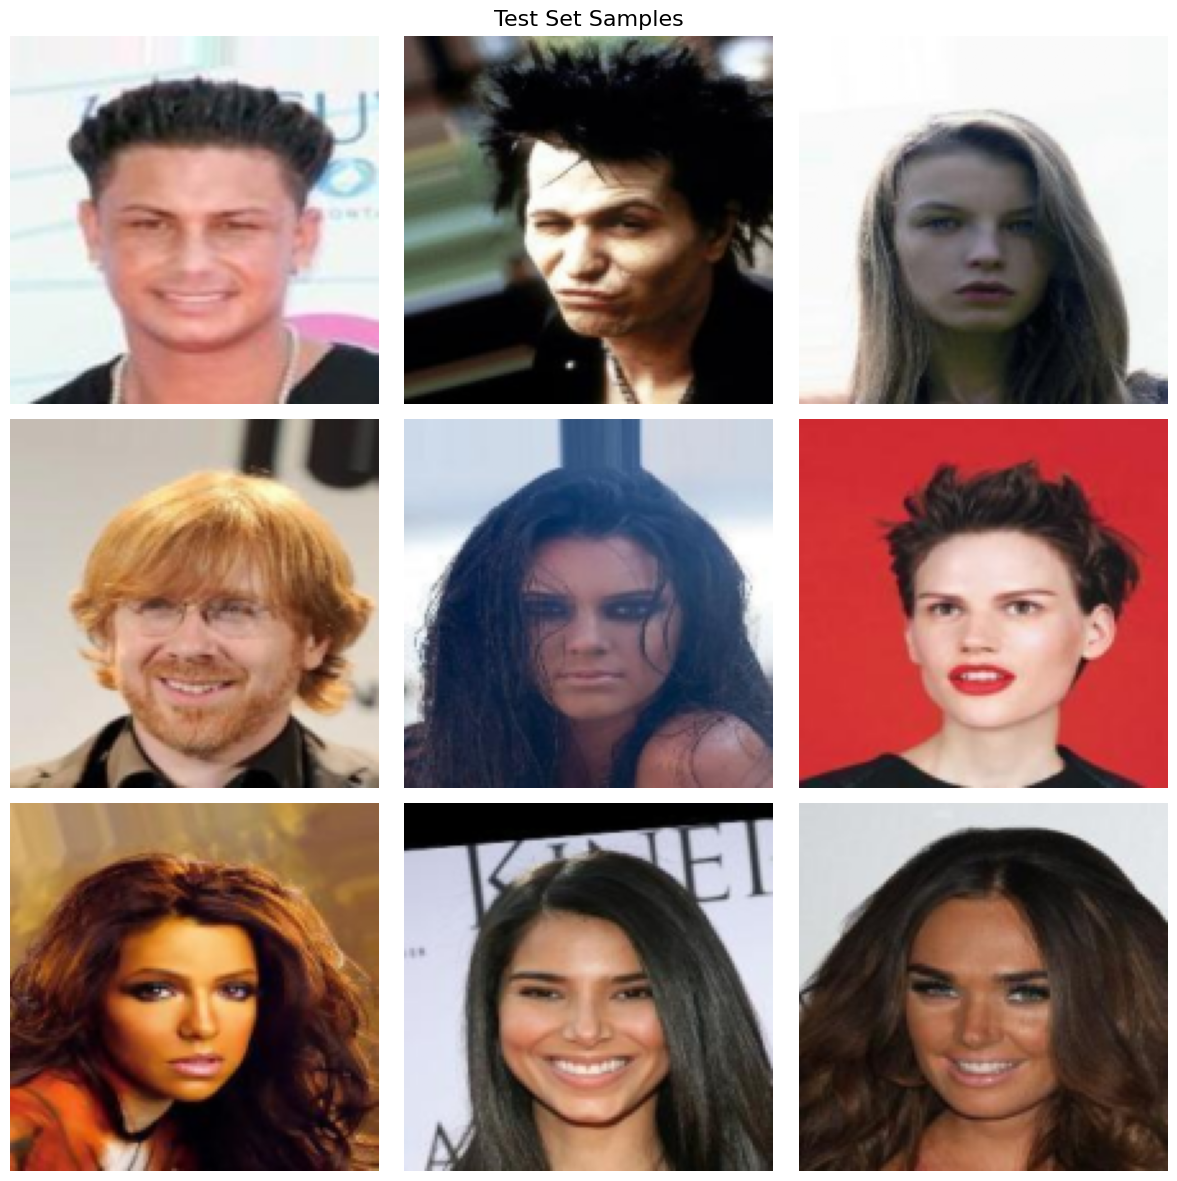

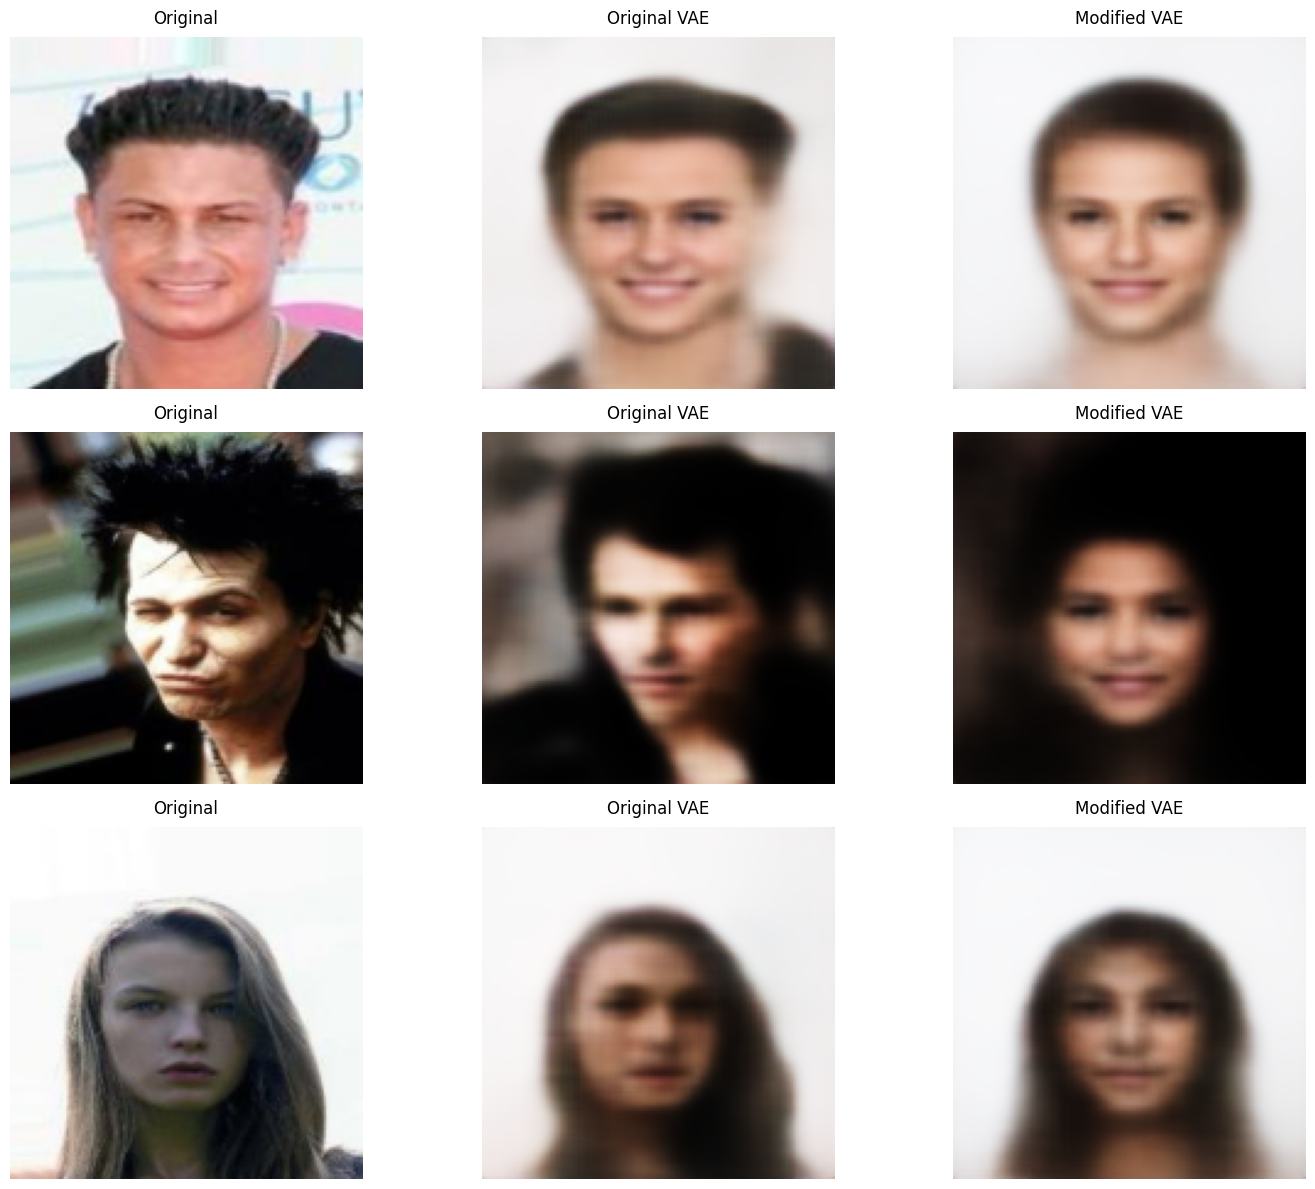

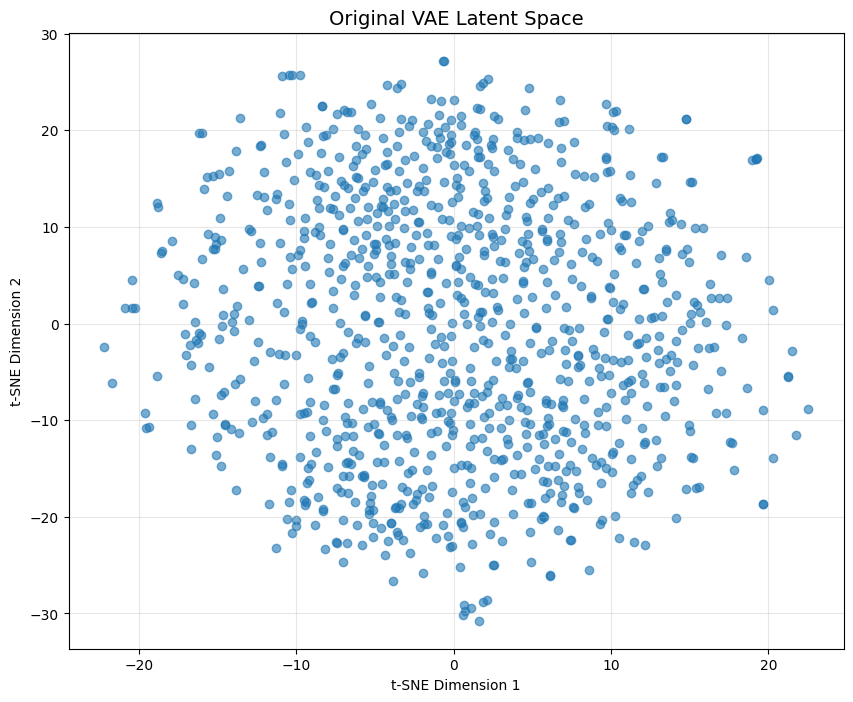

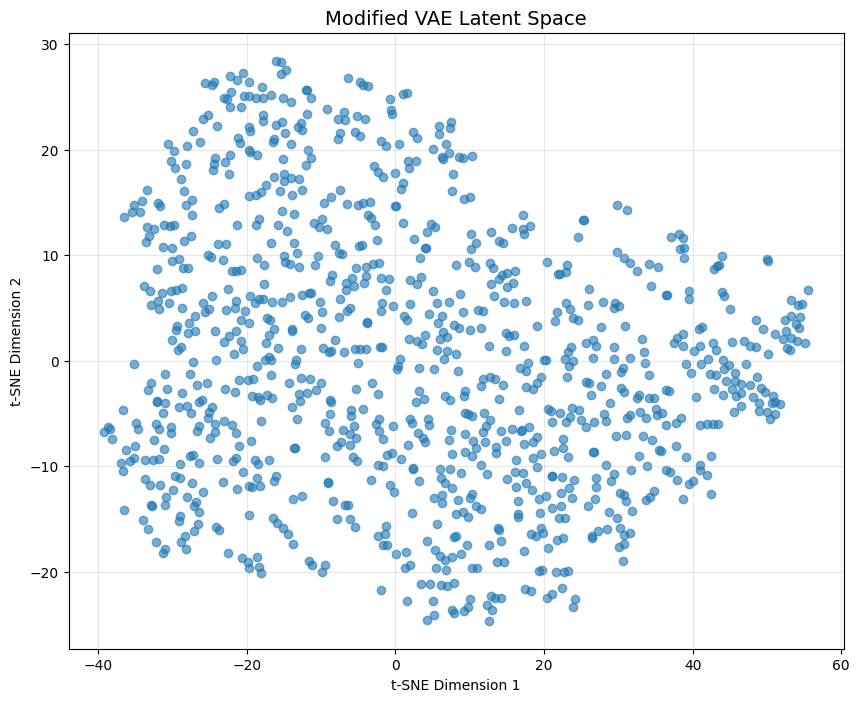

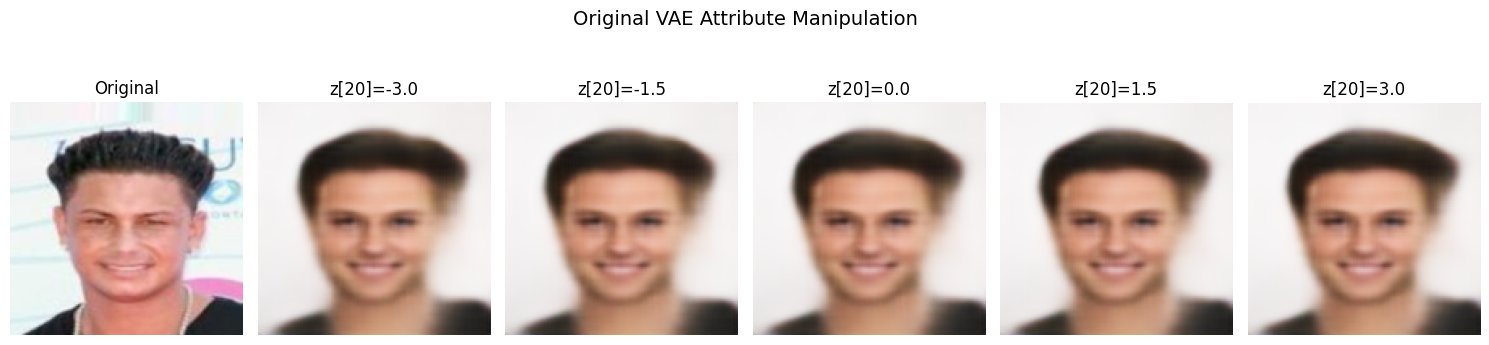

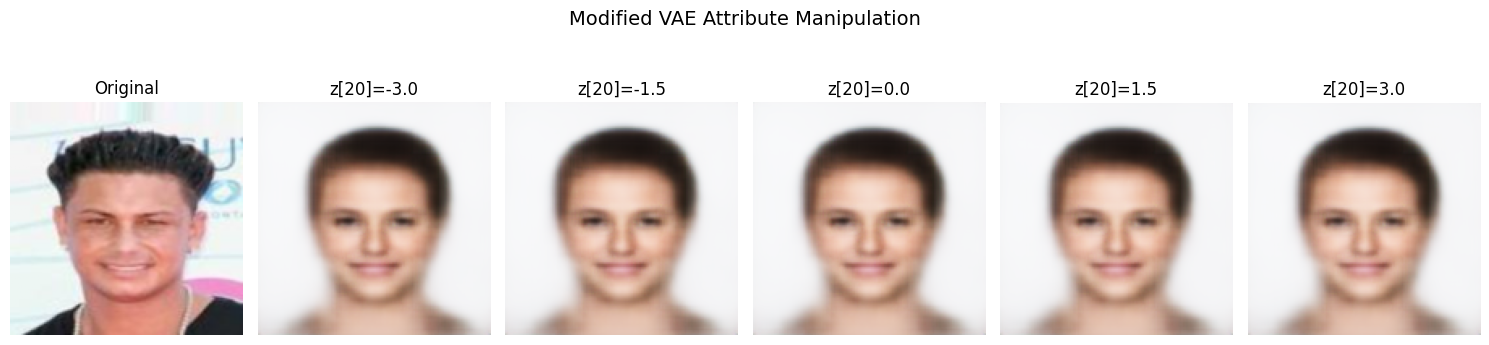

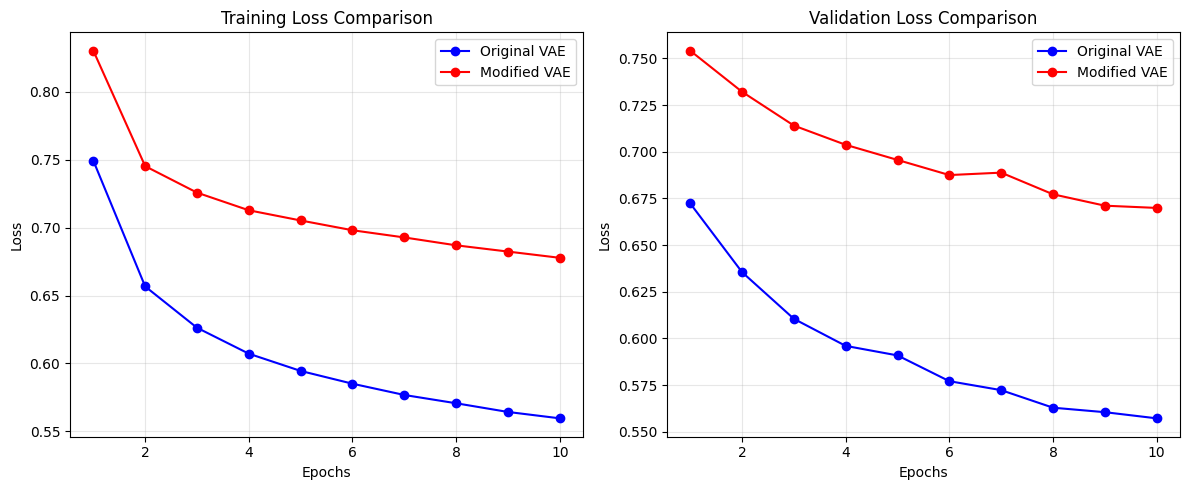

+---------------------+----------------+----------------+
| Metric              | Original VAE   | Modified VAE   |
+=====================+================+================+
| Model Parameters    | 9,352,195      | 6,283,267      |
+---------------------+----------------+----------------+
| Inference Time (ms) | 1.77 ± 0.08    | 10.32 ± 1.13   |
+---------------------+----------------+----------------+
| Parameter Reduction | -              | 32.8%          |
+---------------------+----------------+----------------+
| Speed Ratio         | 1.0x           | 0.2x           |
+---------------------+----------------+----------------+


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.manifold import TSNE
import seaborn as sns
import torch
from torchvision.utils import make_grid
from tabulate import tabulate

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Dataset Samples Visualization
def plot_dataset_samples(dataset, title="CelebA Dataset Samples", num_samples=9):
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        img = dataset[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 2. Model Comparison Visualization
def compare_reconstructions(models, model_names, dataloader, num_samples=3):
    data = next(iter(dataloader))[:num_samples].to(device)

    fig, axes = plt.subplots(num_samples, len(models)+1, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Original image
        axes[i,0].imshow(data[i].cpu().permute(1, 2, 0))
        axes[i,0].set_title("Original", pad=10)
        axes[i,0].axis('off')

        # Reconstructions
        for j, model in enumerate(models):
            with torch.no_grad():
                recon, _, _ = model(data[i].unsqueeze(0))
            axes[i,j+1].imshow(recon[0].cpu().permute(1, 2, 0))
            axes[i,j+1].set_title(model_names[j], pad=10)
            axes[i,j+1].axis('off')

    plt.tight_layout()
    plt.show()

# 3. Latent Space Visualization
def plot_latent_space(model, dataloader, n_samples=1000, title="Latent Space"):
    model.eval()
    latents = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if i >= n_samples//32:
                break
            _, z_mean, _ = model(data.to(device))
            latents.append(z_mean.cpu())

    latents = torch.cat(latents).numpy()

    # t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latents[:n_samples])

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:,0], latent_2d[:,1], alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.3)
    plt.show()

# 4. Attribute Manipulation
def visualize_attribute_manipulation(model, dataloader, latent_dim=20, title="Attribute Manipulation"):
    model.eval()
    data = next(iter(dataloader))[:1].to(device)

    with torch.no_grad():
        # Get latent representation
        z_mean, z_log_var, z = model.encoder(data)

        # Create variations
        variations = []
        for val in torch.linspace(-3, 3, 5):
            modified_z = z.clone()
            modified_z[0, latent_dim] = val
            recon = model.decoder(modified_z)
            variations.append(recon.cpu())

    # Plot
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(data[0].cpu().permute(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    for i, recon in enumerate(variations):
        plt.subplot(1, 6, i+2)
        plt.imshow(recon[0].permute(1, 2, 0))
        plt.title(f"z[{latent_dim}]={-3+i*1.5:.1f}")
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# 5. Loss Comparison
def plot_loss_comparison(original_train_losses, original_val_losses,
                        modified_train_losses, modified_val_losses):
    epochs = range(1, len(original_train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, original_train_losses, 'b-o', label='Original VAE')
    plt.plot(epochs, modified_train_losses, 'r-o', label='Modified VAE')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    # Plot validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, original_val_losses, 'b-o', label='Original VAE')
    plt.plot(epochs, modified_val_losses, 'r-o', label='Modified VAE')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# 6. Performance Metrics
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def measure_inference_time(model, dataloader, n_runs=100):
    model.eval()
    times = []
    data = next(iter(dataloader))[:1].to(device)

    # Warm-up
    with torch.no_grad():
        _ = model(data)

    # Measure
    for _ in range(n_runs):
        start = time.time()
        with torch.no_grad():
            _ = model(data)
        torch.cuda.synchronize()  # If using CUDA
        times.append(time.time() - start)

    return np.mean(times)*1000, np.std(times)*1000  # Convert to milliseconds

def create_metrics_table(orig_time, orig_std, orig_params, mod_time, mod_std, mod_params):
    metrics = [
        ["Model Parameters", f"{orig_params:,}", f"{mod_params:,}"],
        ["Inference Time (ms)", f"{orig_time:.2f} ± {orig_std:.2f}", f"{mod_time:.2f} ± {mod_std:.2f}"],
        ["Parameter Reduction", "-", f"{(1-mod_params/orig_params)*100:.1f}%"],
        ["Speed Ratio", "1.0x", f"{orig_time/mod_time:.1f}x"]
    ]

    print(tabulate(metrics,
                 headers=["Metric", "Original VAE", "Modified VAE"],
                 tablefmt="grid",
                 numalign="center"))

# ====================== MAIN EXECUTION ====================== #

# 1. Show dataset samples
plot_dataset_samples(test_loader.dataset, "Test Set Samples")

# 2. Compare reconstructions
compare_reconstructions(
    [original_vae, modified_vae],
    ["Original VAE", "Modified VAE"],
    test_loader,
    num_samples=3
)

# 3. Visualize latent spaces
plot_latent_space(original_vae, test_loader, title="Original VAE Latent Space")
plot_latent_space(modified_vae, test_loader, title="Modified VAE Latent Space")

# 4. Attribute manipulation
visualize_attribute_manipulation(original_vae, test_loader, title="Original VAE Attribute Manipulation")
visualize_attribute_manipulation(modified_vae, test_loader, title="Modified VAE Attribute Manipulation")

# 5. Plot loss comparison (you need to provide your actual loss values)
original_train_losses = [0.7493, 0.6567, 0.6263, 0.6072, 0.5945, 0.5851, 0.5768, 0.5707, 0.5643, 0.5596]
original_val_losses = [0.6723, 0.6355, 0.6105, 0.5960, 0.5909, 0.5771, 0.5723, 0.5629, 0.5605, 0.5572]
modified_train_losses = [0.8303, 0.7453, 0.7258, 0.7128, 0.7053, 0.6981, 0.6928, 0.6870, 0.6824, 0.6778]
modified_val_losses = [0.7541, 0.7321, 0.7140, 0.7037, 0.6956, 0.6875, 0.6888, 0.6772, 0.6711, 0.6699]

plot_loss_comparison(
    original_train_losses, original_val_losses,
    modified_train_losses, modified_val_losses
)

# 6. Performance metrics table
orig_mean, orig_std = measure_inference_time(original_vae, test_loader)
mod_mean, mod_std = measure_inference_time(modified_vae, test_loader)

create_metrics_table(
    orig_mean, orig_std, count_params(original_vae),
    mod_mean, mod_std, count_params(modified_vae)
)